# Example usage of the thermo-mechanical NTFA

Felix Fritzen <fritzen@simtech.uni-stuttgart.de>,
Julius Herb <julius.herb@mib.uni-stuttgart.de>,
Shadi Sharba <shadi.sharba@isc.fraunhofer.de>

University of Stuttgart, Institute of Applied Mechanics, Chair for Data Analytics in Engineering

> **Funding acknowledgment**
> The IGF-Project no.: 21.079 N / DVS-No.: 06.3341 of the
> “Forschungsvereinigung Schweißen und verwandte Verfahren e.V.” of the
> German Welding Society (DVS), Aachener Str. 172, 40223 Düsseldorf, Germany,
> was funded by the Federal Ministry for Economic Affairs and Climate Action (BMWK)
> via the German Federation of Industrial Research Associations (AiF) in accordance
> with the policy to support the Industrial Collective Research (IGF)
> on the orders of the German Bundestag.
>
> Felix Fritzen is funded by the German Research Foundation (DFG) --
> 390740016 (EXC-2075); 406068690 (FR2702/8-1); 517847245 (FR2702/10-1).

## Imports:

In [10]:
import os

import h5py
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

from material_parameters import my_sig_y
from thermontfa import ThermoMechNTFA

plt.rcParams["figure.dpi"] = 400
matplotlib.rc("font", size=14)
colors = ["#004191", "#00BEFF", "tab:orange", "tab:red", "tab:olive", "tab:green", "tab:brown", "tab:pink", "tab:gray", "tab:cyan", "tab:purple", "tab:blue"]
markers = ['o', 'd', 's', '+', '^', 'x', 'p', '*', 'v', '1', 'P', '.']
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=colors)

data_path = "../data"

## Instantiate ThermoMechNTFA material routine:

In [2]:
file_name = os.path.join(data_path, "ntfa", "ms9p_fix_ntfa16_B1-6_10s_N24.h5")
ntfa_material = ThermoMechNTFA(
    file_name=file_name,
    group_name="/",
    sig_y=my_sig_y,
    N_max=24,
)

In [3]:

# basis = [np.sqrt(2/3) * np.array([1., -.5, -.5, 0, 0, 0]),
#          np.sqrt(0.5)*np.array([0., 1., -1., 0, 0, 0]),
#          np.array([0, 0, 0, 1, 0, 0]),
#          np.array([0, 0, 0, 0, 1, 0]),
#          np.array([0, 0, 0, 0, 0, 1]),
#          np.array([1, 1, 1, 0, 0, 0])]

# i_load = 1
# i_theta = 0

# with h5py.File("all_results_ms9p_16x16x16_10s_N24.h5", "r") as F:
#     E = np.array(F["/eps"][i_theta][i_load])
#     fans_S = np.array(F['fans/sig'][i_theta][i_load]) / 1000.
#     fans_S0 = np.array(F['fans/sig0'][i_theta][i_load]) / 1000.
#     fans_S1 = np.array(F['fans/sig1'][i_theta][i_load]) / 1000.
#     test_S = np.array(F['ntfa/sig'][i_theta][i_load]) / 1000.
#     theta = F['/temperature'][i_theta]

# # amp = np.linspace(0, 0.02, 11)
# # E = amp[:, None] * \
# #     basis[i_load]
# # print(E)
# T = np.ones(E.shape[0])*theta
# q = 0.
# xi = np.zeros(ntfa_material.n_modes)
# S = np.zeros(6)
# Spred = np.zeros(6)
# C = np.zeros((6, 6))
# deps = np.zeros(6)
# ntfa_S = np.zeros_like(E)
# for i in range(E.shape[0]):
#     eps = E[i]
#     if (i > 0):
#         deps = E[i]-E[i-1]
#     else:
#         deps = np.zeros(6)
#     theta = T[i]
#     Spred = (S + C@deps)
#     xi_n = xi
#     S, q, xi, C = ntfa_material.solve(eps, deps, theta, q, xi)
#     # recast into MPa (instead of kPa)
#     ntfa_S[i, :] = S/1000.
#     pred_err = np.linalg.norm(Spred-S)/np.linalg.norm(S)
#     print(f'step {i+1:3d} ... S: {S/1000}  (lin. error: {pred_err*100:5.1f}%)')


# fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# amp = np.linalg.norm(E, axis=1)
# ax.plot(amp, np.linalg.norm(fans_S - ntfa_S, axis=1) /
#         np.linalg.norm(fans_S, axis=1))
# ax.plot(amp, np.linalg.norm(test_S - ntfa_S, axis=1) /
#         np.linalg.norm(test_S, axis=1))


# with np.set_printoptions( threshold=20, edgeitems=10, linewidth=140,
#     formatter = dict( float = lambda x: "%.3g" % x )):

In [4]:
theta_list = np.linspace(300.0, 1300.0, 5)
eps_list = []
sig_list = []
sig0_list = []
sig1_list = []
q_list = []
xi_list = []
with h5py.File(os.path.join(data_path, "ms9p_uniaxial_stress_data_mod.h5"), "w") as F:
    for iload in range(6):
        G = F.create_group(f"loading{iload:1d}")
        # part 1: theta ramp up in 5 steps
        # part 2: add on top a uniaxial loading
        for theta in theta_list:
            eps_idx = np.array(
                [
                    iload,
                ]
            )
            sig_idx = np.setdiff1d(np.arange(6), eps_idx)
            eps = np.zeros(6)
            eps[eps_idx] = 1.0
            eps = np.linspace(0, 0.02, 11)[:, None] * eps
            ntfa_material.interpolate(theta)
            eps_th_el = -np.linalg.solve(ntfa_material.C, ntfa_material.s_th)

            (
                eps_initial,
                sig_initial,
                C_initial,
                q_initial,
                xi_initial,
            ) = ntfa_material.UMAT_mixed(
                eps_idx=None,
                eps_n=np.zeros(6),
                deps=np.zeros(6),
                sig_bc=np.zeros(6),
                theta=theta,
                q_n=0.0,
                xi_n=np.zeros(ntfa_material.n_modes),
            )
            print("q_ini: ", q_initial, eps_initial - eps_th_el)

            # eps = eps + eps_th_el[None, :]
            eps = eps + eps_initial
            # ntfa_material.A@eps[0] + ntfa_material.t_xi,
            # print("tau_initial: ",  np.linalg.norm( ntfa_material.A@eps[0] + ntfa_material.t_xi),
            #       ";  sig_f: ", ntfa_material.sig_y(theta,0.,False) * np.sqrt(2./3.) * ntfa_material.v_frac[0])
            # print("before: ", eps[0])
            xi = np.zeros(ntfa_material.n_modes)
            q = 0.0
            C = np.zeros((6, 6))
            np.set_printoptions(formatter=dict(float=lambda x: "%10.3g" % x))
            sig = np.zeros_like(eps)
            sig0 = np.zeros_like(eps)
            sig1 = np.zeros_like(eps)
            xi = np.zeros((eps.shape[0], ntfa_material.n_modes))
            q = np.zeros(eps.shape[0])
            q_n = 0
            xi_n = np.zeros(ntfa_material.n_modes)
            for i in range(eps.shape[0]):
                if i == 0:
                    deps = eps[0].copy()
                    eps_n = np.zeros(6)
                else:
                    deps = eps[i] - eps[i - 1]
                    eps_n = eps[i - 1]
                eps[i], sig[i], C, q[i], xi[i] = ntfa_material.UMAT_mixed(
                    eps_idx, eps_n, deps, np.zeros(6), theta, q_n, xi_n
                )
                xi_n = xi[i].copy()
                q_n = q[i]
                sig0[i] = ntfa_material.stress(eps[i], theta, xi[i], i_phase=0)
                sig1[i] = ntfa_material.stress(eps[i], theta, xi[i], i_phase=1)
                # if( i==0 ):
                #     eps_th_el = np.zeros(6)
                #     eps_th_el = - np.linalg.solve(ntfa_material.C, ntfa_material.s_th )
                #     # eps_th_el[sig_idx] = - np.linalg.solve(ntfa_material.C[sig_idx,:][:,sig_idx],
                #                                              ntfa_material.s_th[sig_idx] )
                #     print( f"theta: {theta:6.1f} -- ", (eps[i] - eps_th_el), q[i] )
                # print(f'{i:3d} - {sig[i]} - {q[i]:6.4f}')
            # print("after:  ", eps[0], q[0])
            # print(eps)
            eps_list.append(eps)
            sig_list.append(sig)
            sig0_list.append(sig0)
            sig1_list.append(sig1)
            xi_list.append(xi)
            q_list.append(q)
            # print(f"ntfa_T{theta:06.1f}")
            GG = G.create_group(f"ntfa_T{theta:06.1f}")
            GG.create_dataset("eps", data=eps)
            GG.create_dataset("sig", data=sig)
            GG.create_dataset("sig0", data=sig0)
            GG.create_dataset("sig1", data=sig1)
            GG.create_dataset("q", data=q)
            GG.create_dataset("xi", data=xi)

q_ini:  0.0 [0. 0. 0. 0. 0. 0.]
q_ini:  0.0018869620045771874 [  8.27e-05   7.42e-05    8.3e-05  -1.71e-05  -1.67e-05  -1.67e-05]
q_ini:  0.00755855857911729 [  0.000363   0.000361   0.000354  -0.000125  -0.000125  -0.000125]
q_ini:  0.013277720241141709 [  0.000754   0.000757   0.000775  -0.000273  -0.000274  -0.000274]
q_ini:  0.01685502141630085 [   0.00138    0.00138    0.00139  -0.000249   -0.00025   -0.00025]
q_ini:  0.0 [         0          0          0          0          0          0]
q_ini:  0.0018869620045771874 [  8.27e-05   7.42e-05    8.3e-05  -1.71e-05  -1.67e-05  -1.67e-05]
q_ini:  0.00755855857911729 [  0.000363   0.000361   0.000354  -0.000125  -0.000125  -0.000125]
q_ini:  0.013277720241141709 [  0.000754   0.000757   0.000775  -0.000273  -0.000274  -0.000274]
q_ini:  0.01685502141630085 [   0.00138    0.00138    0.00139  -0.000249   -0.00025   -0.00025]
q_ini:  0.0 [         0          0          0          0          0          0]
q_ini:  0.0018869620045771874 [  8

In [5]:

# run uniaxial strain controlled tests at different temperatures
# the initial state is gained by ramping up the temperature from 293 K
# subsequently, a strain controlled loading is superimposed in the iload-th
# component (2% loading).


theta_list = np.linspace(300.0, 1300.0, 5)
eps_list = []
sig_list = []
sig0_list = []
sig1_list = []
q_list = []
xi_list = []
n_ramp = 10
with h5py.File(os.path.join(data_path, "ms9p_uniaxial_stress_data_mod.h5"), "w") as F:
    for iload in range(6):
        G = F.create_group(f"loading{iload:1d}")
        # part 1: theta ramp up in 5 steps
        # part 2: add on top a uniaxial loading
        for theta in theta_list:
            eps_idx = np.array(
                [
                    iload,
                ]
            )
            sig_idx = np.setdiff1d(np.arange(6), eps_idx)
            eps = np.zeros(6)
            eps[eps_idx] = 1.0
            # the actual loading we are seeking:
            eps_bc = np.zeros((10 + n_ramp, 6))
            eps_bc[(n_ramp - 1) :, eps_idx] = np.linspace(0, 0.02, 11)[:, None]

            # part 1: ramp up theta from 293 K to theta
            T = np.zeros(n_ramp + 10)
            theta_ramp = np.linspace(293.0, theta, n_ramp)
            T[:n_ramp] = theta_ramp
            T[n_ramp:] = theta

            # ntfa_material.A@eps[0] + ntfa_material.t_xi,
            # print("tau_initial: ",  np.linalg.norm( ntfa_material.A@eps[0] + ntfa_material.t_xi),
            #       ";  sig_f: ", ntfa_material.sig_y(theta,0.,False) * np.sqrt(2./3.) * ntfa_material.v_frac[0])
            # print("before: ", eps[0])
            xi = np.zeros(ntfa_material.n_modes)
            q = 0.0
            C = np.zeros((6, 6))
            np.set_printoptions(formatter=dict(float=lambda x: "%10.3g" % x))
            eps = np.zeros_like(eps_bc)
            sig = np.zeros_like(eps)
            sig0 = np.zeros_like(eps)
            sig1 = np.zeros_like(eps)
            xi = np.zeros((eps.shape[0], ntfa_material.n_modes))
            q = np.zeros(eps.shape[0])
            q_n = 0.0
            xi_n = np.zeros(ntfa_material.n_modes)
            for i in range(eps.shape[0]):
                t = T[i]
                if i == 0:
                    deps = eps_bc[0].copy()
                    eps_n = np.zeros(6)
                else:
                    deps = eps_bc[i] - eps[i - 1]
                    eps_n = eps[i - 1]
                if i < n_ramp:
                    # this induces stress free loading with free strains
                    eps_idx = None
                else:
                    eps_idx = np.array(
                        [
                            iload,
                        ]
                    )
                eps[i], sig[i], C, q[i], xi[i] = ntfa_material.UMAT_mixed(
                    eps_idx=eps_idx,
                    eps_n=eps_n,
                    deps=deps,
                    sig_bc=np.zeros(6),
                    theta=t,
                    q_n=q_n,
                    xi_n=xi_n,
                )
                xi_n = xi[i].copy()
                q_n = q[i]
                sig0[i] = ntfa_material.stress(eps[i], t, xi[i], i_phase=0)
                sig1[i] = ntfa_material.stress(eps[i], t, xi[i], i_phase=1)
                # print(t, eps[i], q[i])
                if i == n_ramp - 1:
                    # update the BC!
                    eps_bc[n_ramp:, :] += eps[n_ramp - 1][None, :]
                    # print(t, eps[i], q[i])
                # if( i==0 ):
                #     eps_th_el = np.zeros(6)
                #     eps_th_el = - np.linalg.solve(ntfa_material.C, ntfa_material.s_th )
                #     # eps_th_el[sig_idx] = - np.linalg.solve(ntfa_material.C[sig_idx,:][:,sig_idx],
                #                                              ntfa_material.s_th[sig_idx] )
                #     print( f"theta: {theta:6.1f} -- ", (eps[i] - eps_th_el), q[i] )
                # print(f'{i:3d} - {sig[i]} - {q[i]:6.4f}')
            # print("after:  ", eps[0], q[0])
            # print(eps)
            eps_list.append(eps)
            sig_list.append(sig)
            sig0_list.append(sig0)
            sig1_list.append(sig1)
            xi_list.append(xi)
            q_list.append(q)
            # print(f"ntfa_T{theta:06.1f}")
            GG = G.create_group(f"ntfa_T{theta:06.1f}")
            GG.create_dataset("T", data=T)
            GG.create_dataset("eps", data=eps)
            GG.create_dataset("sig", data=sig)
            GG.create_dataset("sig0", data=sig0)
            GG.create_dataset("sig1", data=sig1)
            GG.create_dataset("q", data=q)
            GG.create_dataset("xi", data=xi)

In [6]:
# 1. set the stress to 0
# 2. ramp the temperature from 293K
# 3. check for q >= q_crit_0, q_crit_1, ...
#    e.g. q_crit_0 = 0.002 (i.e. 0.2%)
# draw the results of theta

n_ramp = 1300 - 293 + 1
with h5py.File(os.path.join(data_path, "ms9p_thermal_rampup.h5"), "w") as F:
    eps_idx = None
    sig_idx = np.arange(6)
    eps = np.zeros(6)
    # the actual loading we are seeking:
    eps_bc = np.zeros((n_ramp, 6))

    # part 1: ramp up theta from 293 K to theta
    T = np.linspace(293.0, 1300.0, n_ramp)
    q = 0.0
    C = np.zeros((6, 6))
    np.set_printoptions(formatter=dict(float=lambda x: "%10.3g" % x))
    eps = np.zeros_like(eps_bc)
    sig = np.zeros_like(eps)
    sig0 = np.zeros_like(eps)
    sig1 = np.zeros_like(eps)
    xi = np.zeros((eps.shape[0], ntfa_material.n_modes))
    q = np.zeros(eps.shape[0])
    q_n = 0.0
    xi_n = np.zeros(ntfa_material.n_modes)
    for i in range(eps.shape[0]):
        t = T[i]
        if i == 0:
            deps = eps_bc[0].copy()
            eps_n = np.zeros(6)
        else:
            deps = eps_bc[i] - eps[i - 1]
            eps_n = eps[i - 1]
        eps[i], sig[i], C, q[i], xi[i] = ntfa_material.UMAT_mixed(
            eps_idx, eps_n, deps, np.zeros(6), t, q_n, xi_n
        )
        xi_n = xi[i].copy()
        q_n = q[i]
        sig0[i] = ntfa_material.stress(eps[i], t, xi[i], i_phase=0)
        sig1[i] = ntfa_material.stress(eps[i], t, xi[i], i_phase=1)
        # print(t, eps[i], q[i])
    # print(f"ntfa_T{theta:06.1f}")
    F.create_dataset("T", data=T)
    F.create_dataset("eps", data=eps)
    F.create_dataset("sig", data=sig)
    F.create_dataset("sig0", data=sig0)
    F.create_dataset("sig1", data=sig1)
    F.create_dataset("q", data=q)
    F.create_dataset("xi", data=xi)

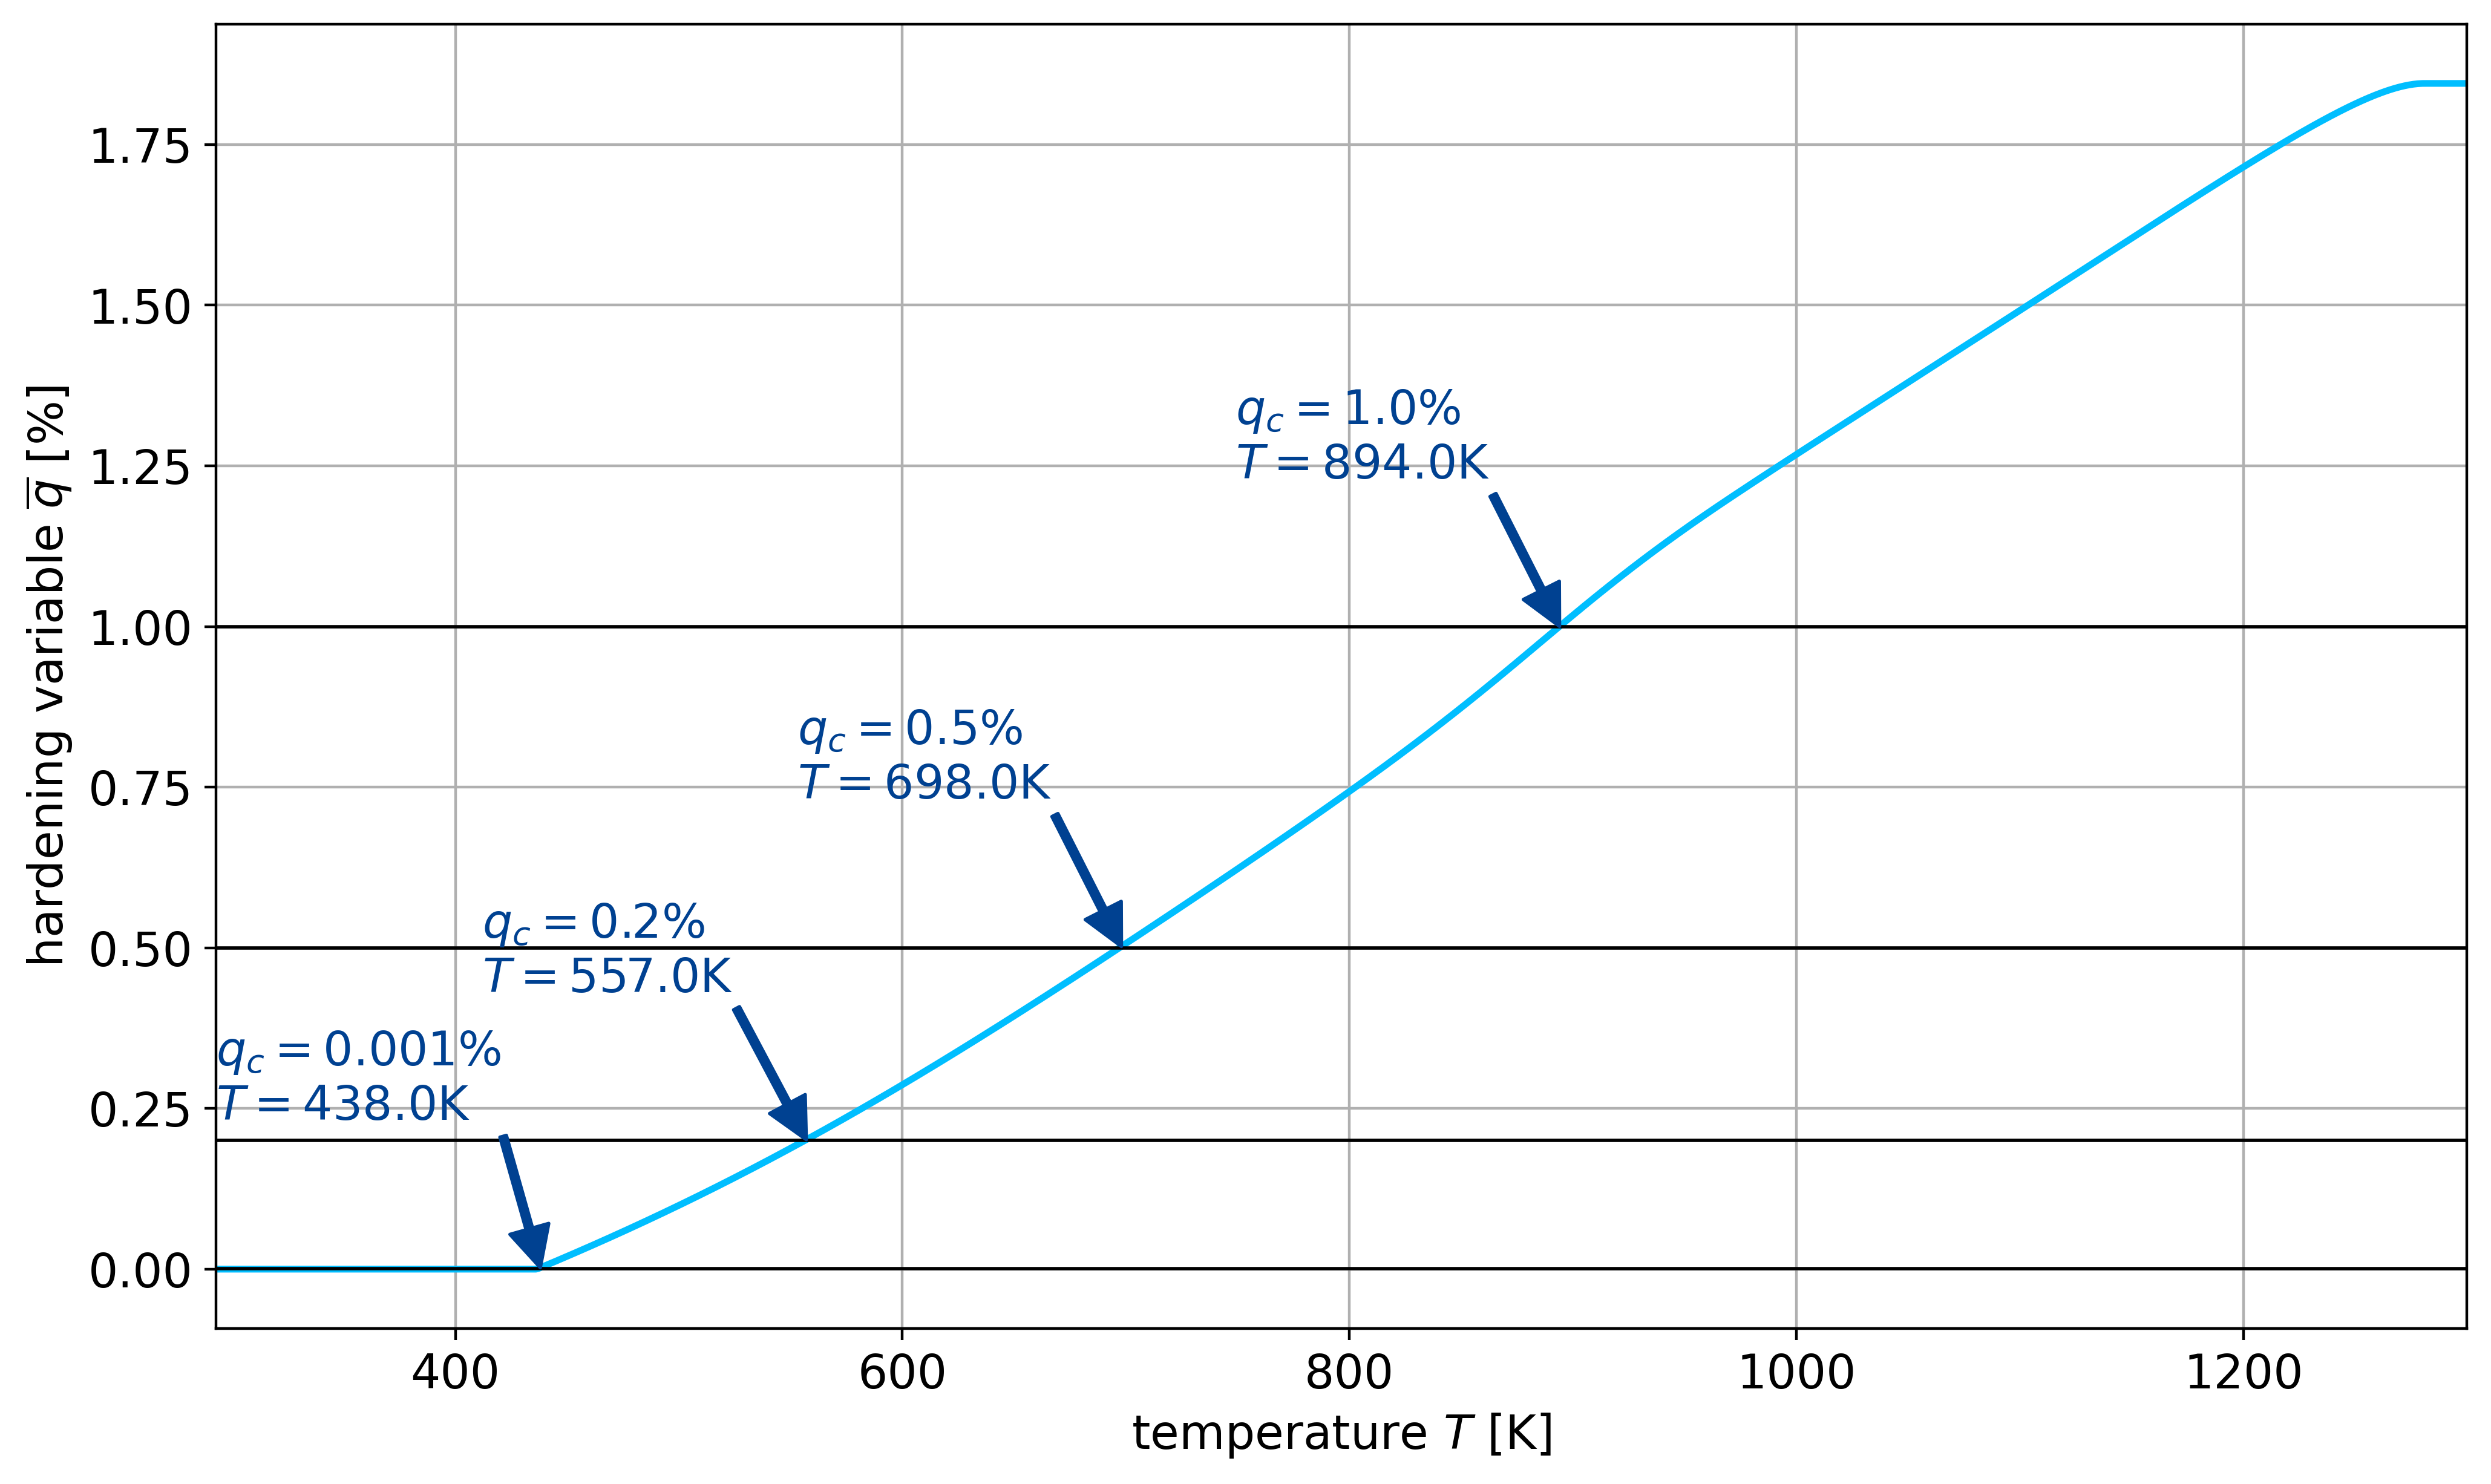

In [16]:
q_crit = [1e-5, 0.002, 0.005, 0.01]
with h5py.File(os.path.join(data_path, "ms9p_thermal_rampup.h5"), "r") as F:
    q = np.array(F["q"])
    T = np.array(F["T"])
    eps = np.array(F["eps"])
    sig0 = np.array(F["sig0"])
    sig1 = np.array(F["sig1"])
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    ax.plot(T, 100 * q, color=colors[1], lw=2, label=r"NTFA $\overline{q}$")
    for qc in q_crit:
        ax.plot([T[0], T[-1]], [100 * qc, 100 * qc], color="black", lw=1)
        i = np.searchsorted(q, qc)
        ax.annotate(
            text=f"$q_c={qc * 100}\%$\n$T={T[i]}\mathrm{{K}}$",
            xy=[T[i], 100 * q[i]],
            xytext=[T[i] - 145, 100 * q[i] + 0.23],
            color=colors[0],
            arrowprops=dict(width=2, color=colors[0]),
        )

ax.grid()
ax.set_xlim(T[0], T[-1])
ax.set_xlabel(r"temperature $T$ [K]")
ax.set_ylabel(r"hardening variable $\overline{q}$ [%]")
plt.show()

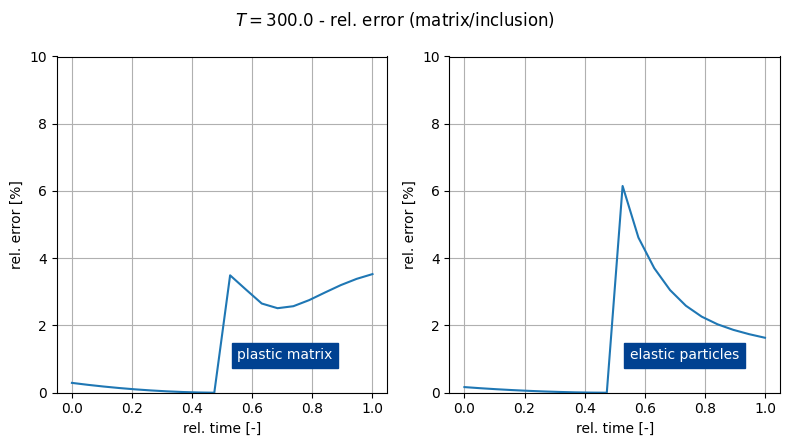

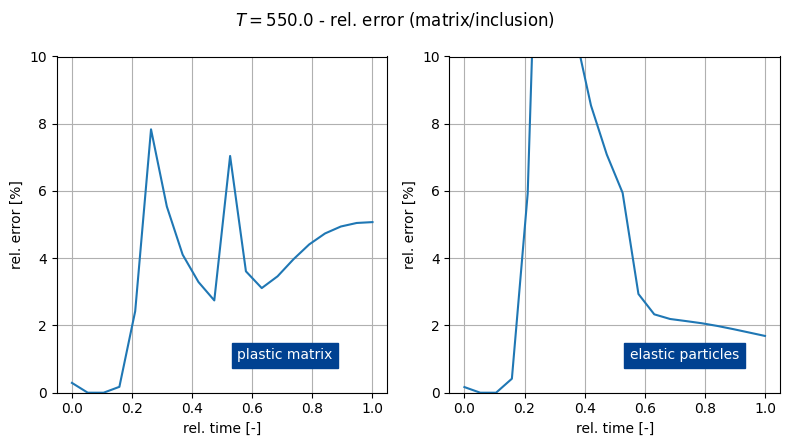

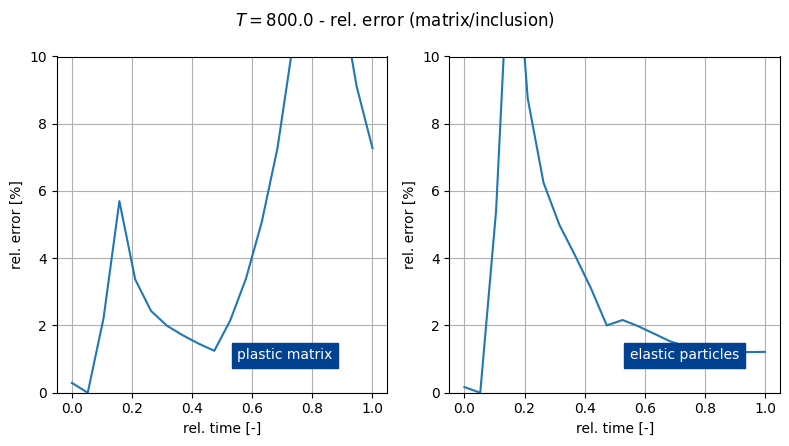

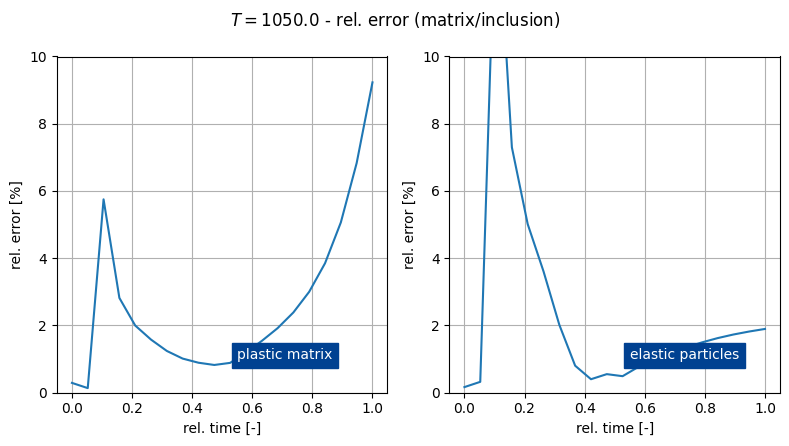

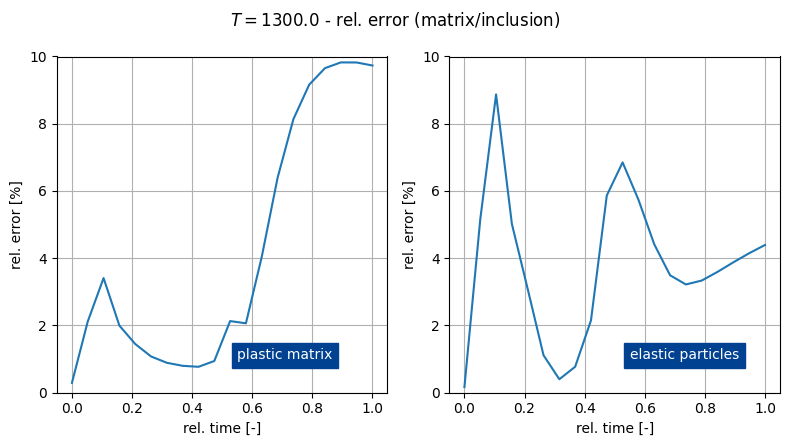

In [8]:


sig_fe_list = []
sig0_fe_list = []
sig1_fe_list = []

# with h5py.File("ms9p_uniaxial_stress_data_loading0-5.h5", "r") as F:
with h5py.File(
    os.path.join(data_path, "loadcases", "ms9p_uniaxial_stress_data_mod_loading0.h5"),
    "r",
) as F:
    for iload in range(1):
        G = F[f"loading{iload:1d}"]
        for theta in theta_list:
            GG = G[f"ntfa_T{theta:06.1f}"]
            sig_fe = np.array(GG["fe_sig"])
            sig0_fe = np.array(GG["fe_sig0"])
            sig1_fe = np.array(GG["fe_sig1"])
            sig_fe_list.append(sig_fe)
            sig0_fe_list.append(sig0_fe)
            sig1_fe_list.append(sig1_fe)


def rel_error(A, A_ref, r_min=None):
    if r_min is None:
        return np.linalg.norm(A - A_ref, axis=1) / np.linalg.norm(A_ref, axis=1)
    else:
        return np.linalg.norm(A - A_ref, axis=1) / (
            np.maximum(r_min, np.linalg.norm(A_ref, axis=1))
        )


n = len(sig_fe_list)

for k in [0, 1, 2, 3, 4]:
    fig, ax = plt.subplots(1, 2, figsize=(8, 4.5))
    # fig.suptitle(rf"$T={theta_list[np.mod(k,5)]}$ - rel. error (overall/matrix/inclusion)")
    temp = theta_list[np.mod(k, 5)]
    fig.suptitle(rf"$T={temp}$ - rel. error (matrix/inclusion)")
    c1 = ntfa_material.v_frac[0]
    c2 = ntfa_material.v_frac[1]
    sig_list[k] = c1 * sig0_list[k] + c2 * sig1_list[k]
    # delta =   c1 * sig0_list[k] + c2 * sig1_list[k] - sig_list[k]
    # print(rel_error(  c1 * sig0_fe_list[k] + c2 * sig1_fe_list[k], sig_fe_list[k] ))
    err_sig = rel_error(sig_list[k], sig_fe_list[k], r_min=1e4)
    err_sig0 = rel_error(sig0_list[k], sig0_fe_list[k], r_min=1e4)
    err_sig1 = rel_error(sig1_list[k], sig1_fe_list[k], r_min=1e4)
    t = np.linspace(0, 1, sig_list[k].shape[0])
    ax[0].plot(t[:], err_sig0[:] * 100)
    ax[1].plot(t[:], err_sig1[:] * 100)
    for A in ax:
        A.grid()
        A.set_xlabel("rel. time [-]")
        A.set_ylabel("rel. error [%]")
        A.set_ylim([0, 10])
    ax[0].text(0.55, 1, "plastic matrix", backgroundcolor="#004191", color="white")
    ax[1].text(0.55, 1, "elastic particles", backgroundcolor="#004191", color="white")
    fig.tight_layout()
    plt.savefig(
        os.path.join(data_path, "results", f"rel_error_uniaxial_T{temp:.0f}.jpg")
    )
    # ax[0].plot(t[:], err_sig[:]*100)
    # ax[1].plot(t[:], err_sig0[:]*100)
    # ax[2].plot(t[:], err_sig1[:]*100)

    # print( sig_list[k] - ntfa_material.v_frac[0] * sig0_list[k] - ntfa_material.v_frac[1] * sig1_list[k] )
    # print(f'rel. error in sig   {100*err_sig}%')
    # print(f'rel. error in sig0  {100*err_sig0}%')
    # print(f'rel. error in sig1  {100*err_sig1}%')